# Time series models

In [1]:
%matplotlib inline
import os
import sys
import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

import warnings
warnings.filterwarnings('ignore')

***

## Importing the data

In [2]:
def read_data(data_folder, df_cols='all'):
    df_list = []
    df = ''

    for folder in os.listdir(data_folder):
        folder = data_folder + '\\' + folder
        for data in os.listdir(folder):
            file_path = folder + '\\' + data

            if 'street' in data:
                df_list.append(file_path)

    if df_cols == 'all':
        df = pd.concat([pd.read_csv(f) for f in tqdm(
            df_list, position=0, leave=True)], ignore_index=True)
    else:
        df = pd.concat([pd.read_csv(f, usecols=df_cols) for f in tqdm(
            df_list, position=0, leave=True)], ignore_index=True)

    return df

In [3]:
folder = 'Data\\Jan_2010_Oct_2021'
street_cols = ['Month', 'Reported by', 'Falls within', 'Location', 'LSOA code', 'LSOA name', 'Crime type']

street = read_data(folder, street_cols)

100%|██████████| 5839/5839 [03:43<00:00, 26.12it/s]


***
## Cleaning

In [22]:
# deleting nan
na_street = street.dropna(axis=0, how="any")
na_street['Month dt'] = pd.to_datetime(na_street['Month']).dt.to_period('m')
na_street = na_street[ na_street['Month dt'] > '2013-05']

In [25]:
# adding LAD data
conversions = pd.read_csv('Data/conversiontable.csv', encoding="latin-1")

convert_codes = dict(zip(conversions.lsoa11cd, conversions.ladcd))
convert_names = dict(zip(conversions.lsoa11cd, conversions.ladnm))

na_street['LAD code'] = na_street['LSOA code'].map(convert_codes)
na_street['LAD name'] = na_street['LSOA code'].map(convert_names)

***
## Data preparation for the model

In [26]:
# choose a crime and area to train and test the model
area = random.choice(na_street['LAD name'].unique())
area

'Cannock Chase'

In [27]:
def get_y(na_street, area, split_date = '2020-11'):
    harm_index = {'Anti-social behaviour': 184 ,
                'Bicycle theft': 19 ,
                'Burglary': 859 ,
                'Criminal damage and arson': 139 ,
                'Drugs': 139 ,
                'Other crime': 164 ,
                'Other theft': 138 ,
                'Possession of weapons': 456 ,
                'Public disorder and weapons': 365 ,
                'Public order': 431 ,
                'Robbery': 994 ,
                'Shoplifting': 13 ,
                'Theft from the person': 87 ,
                'Vehicle crime': 60 ,
                'Violence and sexual offences': 1019 ,
                'Violent crime'	:1056 }
    
    # create y and ensure it has a DatetimeIndex
    y = na_street[(na_street['LAD name'] == area)][['Month dt','Crime type']]
    y['Crime type'] = y['Crime type'].map(harm_index)
    y = y.groupby('Month dt')['Crime type'].sum()
    y.index = y.index.to_timestamp()
    y = y.to_frame().rename(columns = {0:'amount'})
    
    # select the part thats used for training and the part that's used for testing
    y_train = y[:split_date]
    y_train.drop(y_train.tail(1).index,inplace=True)
    y_test = y[split_date:]
    
    predict_date = len(y) - len(y_train)
    
    return y, y_train, y_test, predict_date

y, y_train, y_test, predict_date = get_y(na_street, area, '2020-10')

## SARIMAX model

In [9]:
def seasonal_decompose_m(y):    
    model = sm.tsa.seasonal_decompose(y, model='additive', extrapolate_trend='freq')
    seasonality = model.seasonal
    
    min_val = seasonality.min()
    first_i = seasonality.to_list().index(min_val)
    second_i = seasonality.to_list().index(min_val, first_i+1)
    m = second_i - first_i
    
    return m

In [10]:
def get_orders(y_train):
    m = seasonal_decompose_m(y_train)

    # use the auto_arima model to retrieve the optimal p q and d values
    best_model = auto_arima(y_train, start_p=0, start_q=0, max_p=10, max_q=10,
                            start_P=0, start_Q=0, max_P=10, max_Q=10, m=m, seasonal=True,
                            trace=False, d=1, D=1, error_action='warn', suppress_warnings=True,
                            random_state=20, n_fits=30)

    # extract the orders for the seasonality and the trend
    order = best_model.order
    seasonal_order = best_model.seasonal_order
    return [order, seasonal_order]
    
def train_sarimax(y_train, orders, with_covid = True, covid_start = '2020-02', covid_end = '2021-10'):
    # extract the period of the seasonal component
   
    if with_covid: # sarimax model
        # Get the covid data
        y_covid = y_train.copy()
        y_covid['Crime type'] = np.where((y_train.index < covid_start) & (y_train.index > covid_end), 0, 1)
        
        # train the model
        model = sm.tsa.statespace.SARIMAX(endog = y_train, exog = y_covid, order=orders[0], seasonal_order=orders[1],
                                      enforce_stationarity=False, enforce_invertibility=False).fit()
    else: # sarima model
        model = sm.tsa.statespace.SARIMAX(endog = y_train, order=orders[0], seasonal_order=orders[1],
                                      enforce_stationarity=False, enforce_invertibility=False).fit()
       
    return model

In [11]:
orders = get_orders(y_train)
sarima_model = train_sarimax(y_train, orders)
sarima_model

NameError: name 'auto_arima' is not defined

## Holt Winters' model

In [19]:
def seasonal_decompose_residuals (y):
    additive = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    multiplicative = sm.tsa.seasonal_decompose(y, model='multiplicative',extrapolate_trend='freq')
    
    types = ['additive', 'multiplicative']
    residual_means = [additive.resid.mean(), multiplicative.resid.mean()]
    best_type = types[list(np.abs(residual_means)).index(min(np.abs(residual_means)))]
    
    return best_type

def seasonal_decompose_type_m(y):
    best_type = seasonal_decompose_residuals(y)
    
    model = sm.tsa.seasonal_decompose(y, model=best_type, extrapolate_trend='freq')
    seasonality = model.seasonal
    
    min_val = seasonality.min()
    first_i = seasonality.to_list().index(min_val)
    second_i = seasonality.to_list().index(min_val, first_i+1)
    m = second_i - first_i
    
    return best_type, m

In [29]:
def holt_win_sea(y_to_train, y_to_test, predict_date):
    best_type, m = seasonal_decompose_type_m(y_to_train)
    
    y_to_test = y_test.values.flatten()
    y_to_train = y_to_train.values.flatten()
    best_type_short = 'add' if best_type == 'additive' else 'mul'
    
    fit1 = ETSModel(endog = y_to_train.astype('float64'), seasonal_periods = m, trend='add', seasonal=best_type_short, damped_trend= False).fit()
    fcast1 = fit1.forecast(predict_date)
    mse1 = ((fcast1 - y_to_test) ** 2).mean()

    fit2 = ETSModel(y_to_train.astype('float64'), seasonal_periods = m, trend='add', seasonal=best_type_short, damped_trend =True).fit()
    fcast2 = fit2.forecast(predict_date)
    mse2 = ((fcast2 - y_to_test) ** 2).mean()

    model = fit1 if mse1<mse2 else fit2
    
    return model

In [30]:
holt_win_model = holt_win_sea(y_train, y_test, predict_date)
holt_win_model

## Getting the predictions and plotting the data

In [33]:
def get_predictions(results, y_test, start_predict = '2020-10', end_predict = '2022-01', 
                    with_covid = True, covid_start = '2020-03', covid_end = '2021-10'):
    
    # Sarima extract prediction ci, values
    if results.__class__.__name__ == 'SARIMAXResultsWrapper':
        if with_covid:
            y_covid_test = y_test.copy()
            y_covid_test['Crime type'] = np.where((y_test.index < covid_start) | (y_test.index > covid_end), 0, 1)
           
            predict = results.get_prediction(start=start_predict, end=end_predict, exog=y_covid_test)
            model = 'Sarimax'
            
        else:
            predict = results.get_prediction(start=start_predict, end=end_predict)
            model = 'Sarima'
        
        ci = predict.conf_int()
        mean_predict = predict.predicted_mean
        
    # Holt winters extract prediction ci, values
    else:
        
        df_simul = results.simulate(nsimulations=len(y_test),repetitions=1000, anchor='end')
        df_simul = pd.DataFrame(df_simul)
        
        lower_CI = []
        upper_CI = []
        
        for i in range(len(y_test)):
            lower_CI.append(df_simul[i].quantile(0.025))
            upper_CI.append(df_simul[i].quantile(0.975))
        
        ci = list(zip(lower_CI, upper_CI))
        ci = pd.DataFrame(ci, columns= ['Lower_CI','Upper_CI'])
        
        mean_predict = ci[['Lower_CI', 'Upper_CI']].mean(axis=1)
        model = 'Holt Winters'
   
    return mean_predict, ci, model

In [32]:
def plot_model(results, area):
    mean_predict, ci, model = get_predictions(results, y_test)
    # plot the values
    fig, ax = plt.subplots(figsize=(9,4))

    ax.plot(y_train.index, y_train.values, c='r', label='training data')
    ax.plot(y_test.index, y_test.values, c='b', label='testing data')
    ax.plot(y_test.index, mean_predict,'-', c='y', label='predicted values')
    ax.fill_between(y_test.index, ci.iloc[:,0], ci.iloc[:,1], label = 'ci', color='y', alpha=0.2)
    ax.set_ylim(0)
    ax.set_title('{} model for police demand in {}'.format(model, area))
    plt.legend()

In [ ]:
plot_model(sarima_model, area)

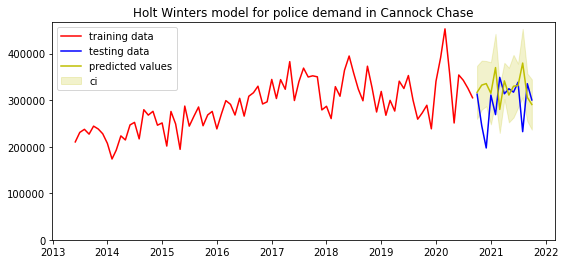

In [34]:
plot_model(holt_win_model, area)

# Testing the models
With [commonly used](https://www.researchgate.net/publication/313991989_Evaluating_and_Comparing_Forecasting_Models) performance [measures](https://www.relataly.com/evaluating-time-series-forecasting-models/923/#h-step-5-calculating-error-metrics)

In [ ]:
from sklearn.metrics import r2_score

def performance_measures(y_test, y_pred):
    y_test = y_test.to_numpy()
    y_pred = y_pred.to_numpy().flatten()
    
    r2 = r2_score(y_test, y_pred)
    mae = np.mean(abs(y_pred - y_test))
    medae = np.median(abs(y_pred - y_test))
    mse = np.square(np.subtract(y_pred, y_test)).mean()
    rmse = np.sqrt(np.mean(np.square(y_pred - y_test)))
    mape = np.mean((np.abs(np.subtract(y_test, y_pred)/ y_test))) * 100
    mdape = np.median((np.abs(np.subtract(y_test, y_pred)/ y_test))) * 100
    
    return [r2, mae, medae, mse, rmse, mape, mdape]

In [ ]:
def ljung_box(results_table):
    summaries = results_table.summary()
    p_ljung_box = pd.read_html(summaries.tables[2].as_html(),index_col=0)[0].loc['Prob(Q):', 1]
    
    return p_ljung_box

In [ ]:
separate_date = '2020-09'

cols = ['r2', 'MAE', 'MedAE', 'MSE', 'RMSE', 'MAPE', 'MDAPE', 'Ljung box']
sarima_df = pd.DataFrame()
sarimax_df = pd.DataFrame()
holt_df = pd.DataFrame()

for area in tqdm( na_street['LAD name'].unique() ):
    
    try:
        y, y_train, y_test, predict_date = get_y(na_street, area, separate_date)
        orders = get_orders(y_train)
        
        sarimax_model = train_sarimax(y_train, orders)
        sarima_model = train_sarimax(y_train, orders, with_covid = False)
        holt_win_model = holt_win_sea(y_train, y_test, predict_date)
        
        sarima_pred, sarima_ci, sarima_model_name = get_predictions(sarima_model, y_test, start_predict = separate_date, with_covid = False)
        sarimax_pred, sarimax_ci, sarimax_model_name = get_predictions(sarimax_model, y_test, start_predict = separate_date)
        holt_win_pred, holt_win_ci, holt_win_model_name = get_predictions(holt_win_model, y_test,  start_predict = separate_date)
        
        sarima_metrics = performance_measures(y_test, sarima_pred)
        sarimax_metrics = performance_measures(y_test, sarimax_pred)
        holt_metrics = performance_measures(y_test, holt_win_pred)
        
        sarima_metrics.append( ljung_box(sarima_model) )
        sarimax_metrics.append( ljung_box(sarimax_model) )
        holt_metrics.append( ljung_box(holt_win_model) )
        
        holt_df = holt_df.append( pd.Series(holt_metrics, index=cols), ignore_index=True)
        sarima_df = sarima_df.append( pd.Series(sarima_metrics, index=cols), ignore_index=True)
        sarimax_df = sarimax_df.append( pd.Series(sarimax_metrics, index=cols), ignore_index=True)
        
    except ValueError:
        # check if these coincide with what patricija found?
        print(area)
        
sarima_df.to_csv('sarima performance metrics.csv')
sarimax_df.to_csv('sarimax performance metrics.csv')
holt_df.to_csv('holt performance metrics.csv')

# Plotting Holtz Winters results of random samples of LAD's

100%|██████████| 20/20 [01:04<00:00,  3.24s/it]


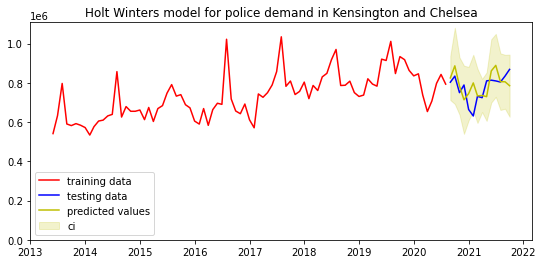

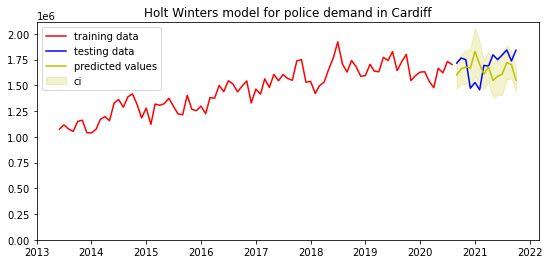

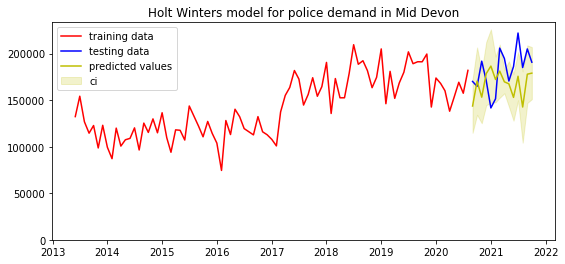

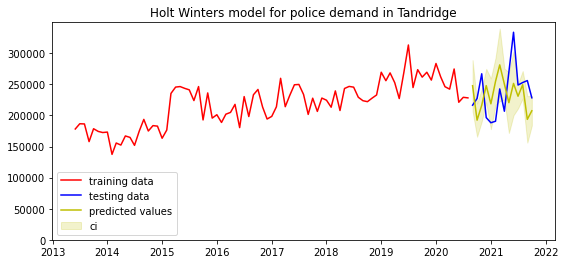

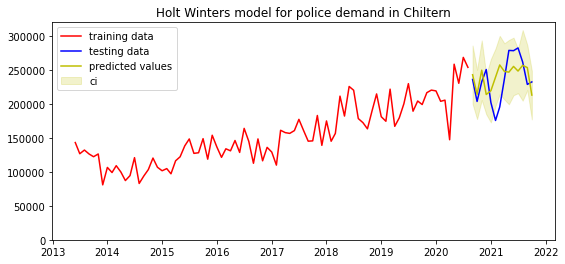

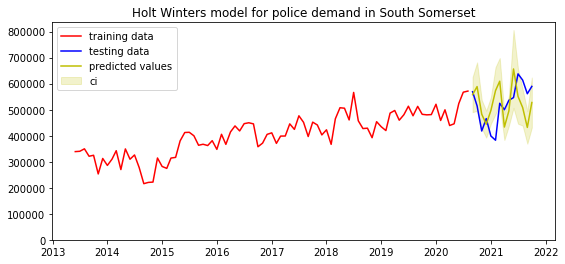

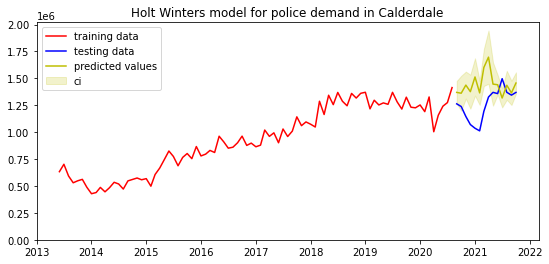

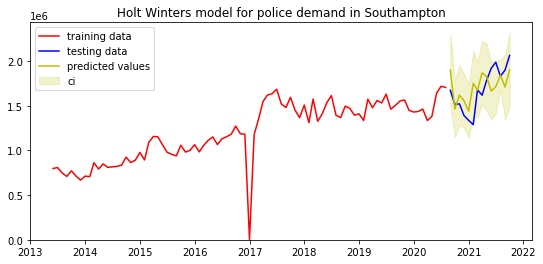

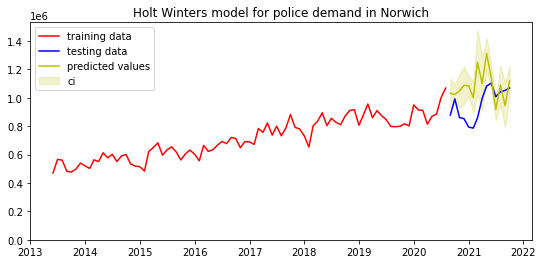

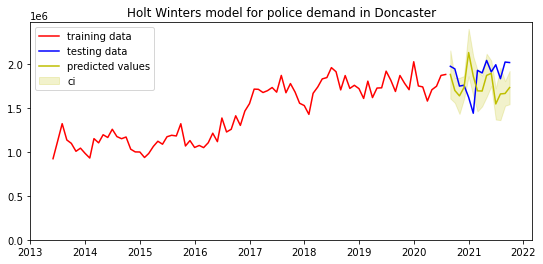

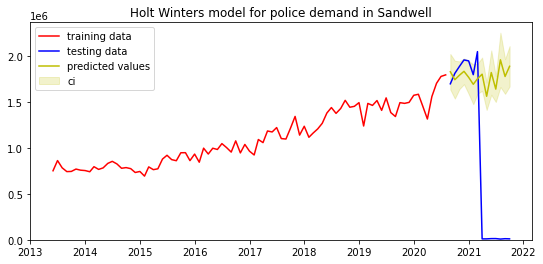

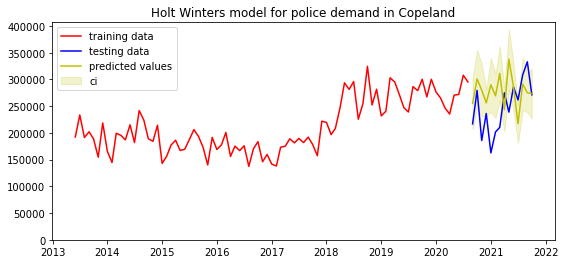

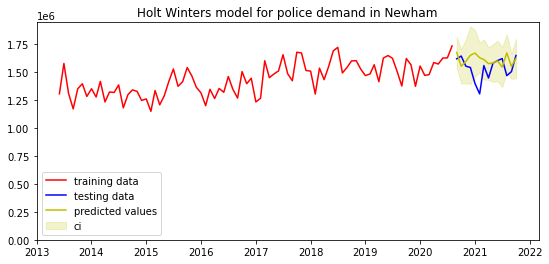

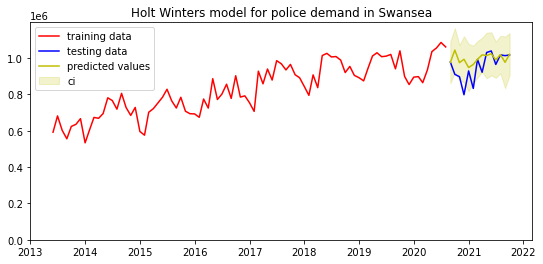

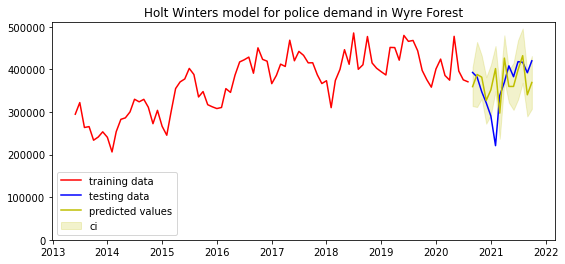

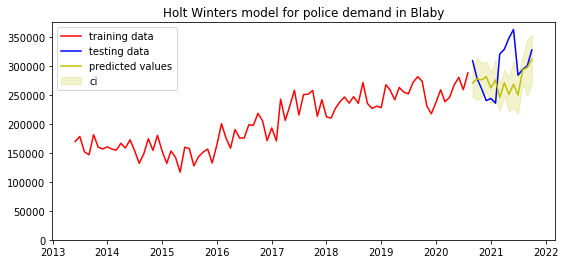

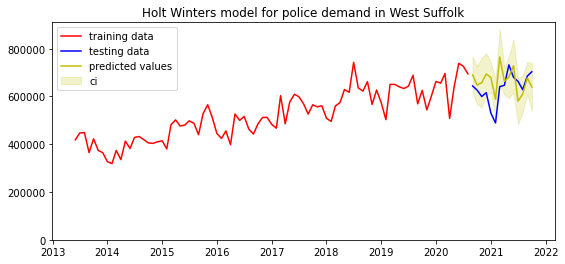

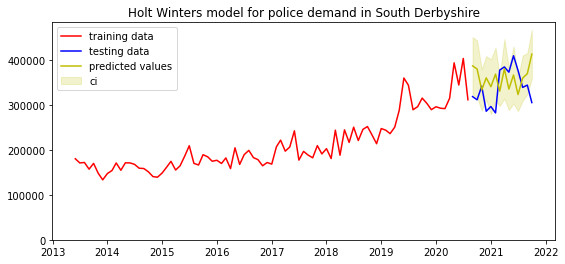

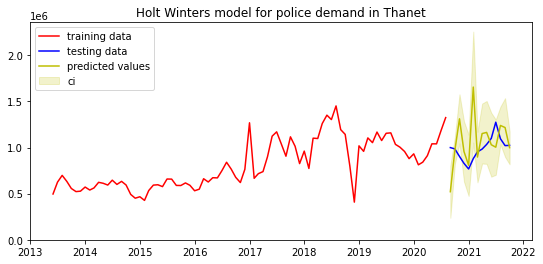

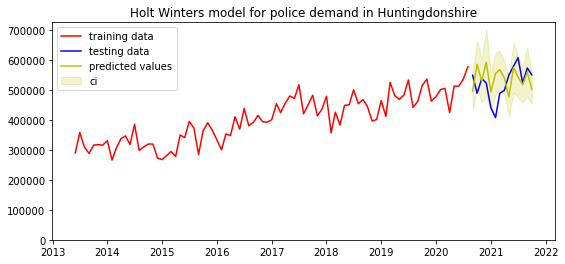

In [41]:
n = 20
separate_date = '2020-09'

for area in tqdm( random.sample(list(na_street['LAD name'].unique()), n) ):
    
    try:
        y, y_train, y_test, predict_date = get_y(na_street, area, separate_date)
        
        holt_win_model = holt_win_sea(y_train, y_test, predict_date)
        

        plot_model(holt_win_model, area)
        plt.savefig(f"hw_samples/svg/{area}.svg")
        plt.savefig(f"hw_samples/png/{area}.png")

        
    except ValueError:
        # check if these coincide with what patricija found?
        print("Encountered error on area", area)
        